In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, accuracy_score
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [2]:
import sys
sys.path.insert(0, '..') 

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Prepping the validation dataframe

In [4]:
from dataset import split_dataframe, JigsawDataset, load_glove_vocab

In [5]:
df = pd.read_csv('../data/train.csv')
_, val_df = split_dataframe(df)

d:\Work\Masters\Courses\[4] Natual Language Processing\Unintended Bias in Toxicity Classification\playground\..\dataset.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_toxic'] = df['target'] >= toxicity_threshold


In [6]:
glove_vocab, glove_embeddings = load_glove_vocab('../data/glove.6B/glove.6B.100d.txt')

In [7]:
test_dataset = JigsawDataset(val_df['comment_text'], val_df['is_toxic'], glove_vocab, max_length=220)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
labels = val_df['target'].tolist()

### Getting the predictions

In [45]:
from model import ToxicityClassifierLSTM

In [49]:
model = ToxicityClassifierLSTM(
        embedding_matrix=glove_embeddings,
        hidden_dim=128,
        output_dim=1,
        num_layers=2,
    )
model = model.to(DEVICE)

In [50]:
model.load_state_dict(torch.load('../checkpoints/LSTM_2.pth', weights_only=False, map_location=DEVICE))

<All keys matched successfully>

In [51]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [52]:
def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs).squeeze(1)
            # predictions = torch.tensor([pred[0] for pred in predictions]).to(device)
            
            all_preds.extend(sigmoid(predictions.detach().cpu().numpy()))
            all_labels.extend(labels.int().cpu().numpy())

    return all_preds, all_labels

In [53]:
preds, binary_labels = predict(model, test_loader, DEVICE)

100%|██████████| 1411/1411 [05:57<00:00,  3.94it/s]


In [54]:
binary_preds = [1 if pred >= 0.4 else 0 for pred in preds]

### Result Anlaysis - LSTM Model 1

High toxicity threshold, so a text is considered toxic only if the toxicity level is high. This is how the training set is, and hence how the model turned out/.

In [55]:
print(f'Accuracy: {100*accuracy_score(binary_labels, binary_preds):0.2f}%')

Accuracy: 84.29%


In [56]:
len(val_df[val_df['is_toxic']==True])

27073

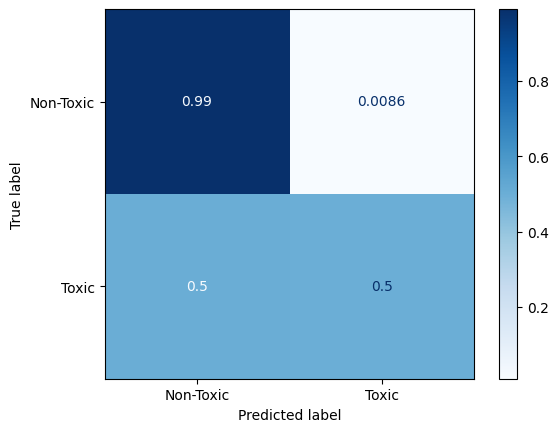

In [57]:
cm = confusion_matrix(binary_labels, binary_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap="Blues")

In [58]:
false_positives = val_df[(np.array(binary_preds) == 0) & (np.array(binary_labels) == 1)]
false_negatives = val_df[(np.array(binary_preds) == 1) & (np.array(binary_labels) == 0)]

len(false_negatives), len(false_positives)

(542, 13635)

In [59]:
false_positives['comment_text'].tolist()[:5]

['Spaying and neutering parents who leave children and pets in the car would be one way to start cleaning up the gene pool.',
 'Right on comrade, and Father Joe can wear a Che Guevera cope at the clown mass.',
 'Lisa, Ohio Dan and Young will have the $tink of Trump on them forever.  They have voted in lock step for all his inept, corrupt cabinet appointees - they are complicit in the damage that will be done to our air and water, the poor, education, medical research, the elderly .... they have even voted against requiring Trump to reveal his taxes. \n\n They have thrown all semblance of decency, truth and honor out the window believing they could use this Tool to push their GOP agenda (and, of course, do the bidding of their fossil fuel contributors.)\n\nThey own this treasonous track record now and forever.  How do they sleep at night ....',
 'I\'ve had it with people falling for the false argument of equivalence because "both sides" committed violence. This isn\'t about the violence

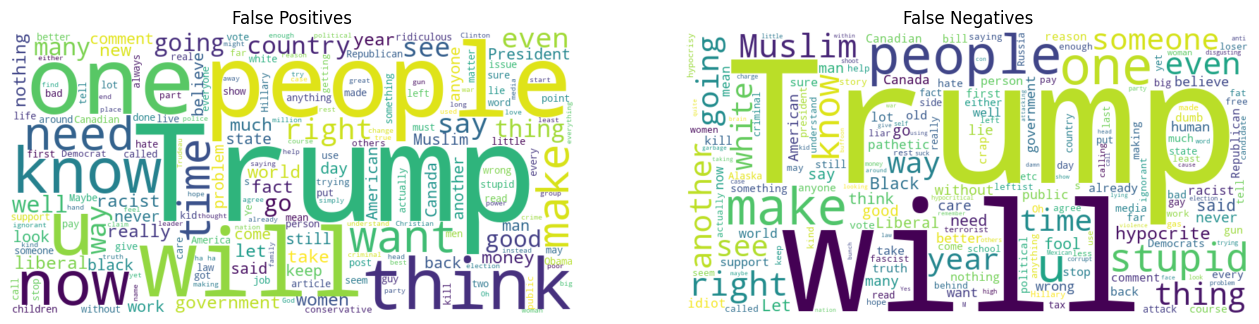

In [58]:
fp_text = " ".join(false_positives['comment_text'])
fn_text = " ".join(false_negatives['comment_text'])

wc_fp = WordCloud(width=800, height=400, background_color="white").generate(fp_text)
wc_fn = WordCloud(width=800, height=400, background_color="white").generate(fn_text)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wc_fp, interpolation="bilinear")
axes[0].set_title("False Positives")
axes[0].axis("off")

axes[1].imshow(wc_fn, interpolation="bilinear")
axes[1].set_title("False Negatives")
axes[1].axis("off")

plt.show()

Precision: 0.97, Recall: 0.44


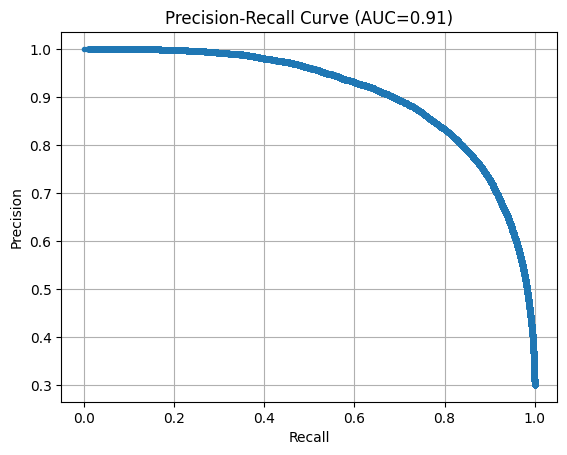

In [60]:
precision, recall, thresholds = precision_recall_curve(binary_labels, preds)
pr_auc = auc(recall, precision)

threshold = 0.5
closest_idx = (np.abs(thresholds - threshold)).argmin()

precision_at_threshold = precision[closest_idx]
recall_at_threshold = recall[closest_idx]
print(f'Precision: {precision_at_threshold:0.2f}, Recall: {recall_at_threshold:0.2f}')

plt.plot(recall, precision, marker=".")
plt.title(f"Precision-Recall Curve (AUC={pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

### Result Anlaysis - LSTM Model 2

Added scheduler, dropout, auxilliary target prediction, class imbalance ratio in loss critera, reduced toxicity threshold to 0.4

In [40]:
print(f'Accuracy: {100*accuracy_score(binary_labels, binary_preds):0.2f}%')

Accuracy: 88.59%


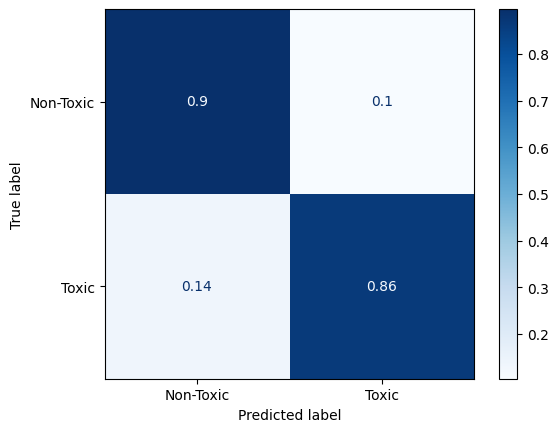

In [41]:
cm = confusion_matrix(binary_labels, binary_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap="Blues")

In [42]:
false_positives = val_df[(np.array(binary_preds) == 0) & (np.array(binary_labels) == 1)]
false_negatives = val_df[(np.array(binary_preds) == 1) & (np.array(binary_labels) == 0)]

len(false_negatives), len(false_positives)

(6567, 3734)

In [43]:
false_positives['comment_text'].tolist()[:5]

['Spaying and neutering parents who leave children and pets in the car would be one way to start cleaning up the gene pool.',
 'this is a serious shame..',
 'The righteousness of the Blue Church will not be dampened by a little thing like attempted murder.',
 "Let's call it what it is: the anti-white male federal jobs program. Canada is leading the way to mediocrity where the future of the workplace is not based on competency, skills or performance but the level of underrepresentedness within special interest groups. This government is driving the country to the same level of competency they have achieved. We will be a well represented 3rd world backwater by the time these 'progressives' are done wrecking this country. Good luck to all, last person turn off the lights.",
 '"...the story of the American family that is the Huckabee family is a heartening one."  Including the part where David Huckabee tortured and then killed a dog by hanging it from a tree?']

Precision: 0.83, Recall: 0.81


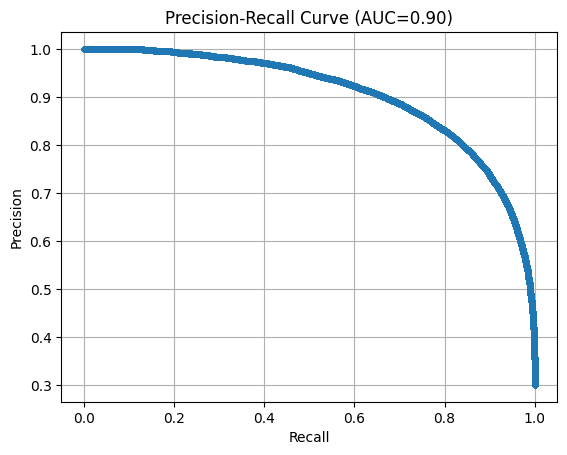

In [44]:
precision, recall, thresholds = precision_recall_curve(binary_labels, preds)
pr_auc = auc(recall, precision)

threshold = 0.5
closest_idx = (np.abs(thresholds - threshold)).argmin()

precision_at_threshold = precision[closest_idx]
recall_at_threshold = recall[closest_idx]
print(f'Precision: {precision_at_threshold:0.2f}, Recall: {recall_at_threshold:0.2f}')

plt.plot(recall, precision, marker=".")
plt.title(f"Precision-Recall Curve (AUC={pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()